In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
# ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


100%|██████████| 428M/428M [00:19<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


### Import dependencies

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.manifold import TSNE

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data

TESS Dataset

In [3]:
dataset_path = '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data'
paths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is loaded')

# dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
print(df.head())

print(df['labels'].value_counts())

Dataset is loaded
                                         audio_paths labels
0  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
1  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
2  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
3  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
4  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
labels
fear       400
sad        400
angry      400
disgust    400
ps         400
neutral    400
happy      400
Name: count, dtype: int64


CREMA-D Dataset

In [4]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)


100%|██████████| 451M/451M [00:21<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


In [5]:
CREMA = '/root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/'
dir_list = os.listdir(CREMA)
dir_list.sort()

emotionG = []
gender = []
emotionO = []
path = []
female_ids = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,
              1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,1052,1053,1054,
              1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,
              1082,1084,1089,1091]

temp_dict = {"SAD":"sad", "ANG": "angry", "DIS":"disgust", "FEA":"fear",
             "HAP":"happy", "NEU":"neutral"}

def get_emotion_crema(filename, ids=female_ids, dc=temp_dict):
  filename = filename.split("_")
  emotionG1 = dc[filename[2]]
  if int(filename[0]) in ids:
    emotionG2 = "_female"
  else:
    emotionG2 = "_male"
  emotionG = emotionG1 + emotionG2
  return (emotionG, emotionG1, emotionG2[1:])


for i in dir_list:
  emotionG.append(get_emotion_crema(i)[0])
  emotionO.append(get_emotion_crema(i)[1])
  gender.append(get_emotion_crema(i)[2])
  path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotionG, columns = ['emotionG_label'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(gender, columns = ['gender'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(emotionO, columns = ['emotion'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

# Filter only emotions that match TESS
valid_emotions = ['neutral', 'sad', 'happy', 'disgust', 'fear', 'angry']
CREMA_df = CREMA_df[CREMA_df['emotion'].isin(valid_emotions)]

CREMA_df.emotionG_label.value_counts()


,count
emotionG_label,
angry_male,671
disgust_male,671
fear_male,671
happy_male,671
sad_male,671
angry_female,600
disgust_female,600
fear_female,600
happy_female,600


### Create Dataset Class

In [6]:
# convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
df['labels'] = df['labels'].map(label_map)


class SpeechDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')


        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)


        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

# split into training and testing
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)




In [7]:
class CREMADataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['emotion']

        # Load and resample audio
        speech, sr = librosa.load(audio_path, sr=16000)

        # Pad or truncate
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Tokenize
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label_map[label], dtype=torch.long)}


# Label mapping from emotions to integers (same as TESS)
label_map = {"neutral": 0, "sad": 1, "happy": 2, "disgust": 3, "fear": 4, "angry": 5}
CREMA_df['labels'] = CREMA_df['emotion'].map(label_map)
crema_train_df, crema_test_df = train_test_split(CREMA_df, test_size=0.2, random_state=42)





In [8]:
# initialize processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)

# load data
train_dataset = SpeechDataset(train_df, processor)
test_dataset = SpeechDataset(test_df, processor)
crema_train_dataset = CREMADataset(crema_train_df, processor)
crema_test_dataset = CREMADataset(crema_test_df, processor)

# print(label_map)
# print(set(test_dataset[i]['labels'].item() for i in range(len(test_dataset))))
# print(set(train_dataset[i]['labels'].item() for i in range(len(train_dataset))))
# print(set(crema_train_dataset[i]['labels'].item() for i in range(len(crema_train_dataset))))
# print(set(crema_test_dataset[i]['labels'].item() for i in range(len(crema_test_dataset))))


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    lr_scheduler_type='cosine',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.01,
    report_to=[]
)

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)

    # Precision, Recall, F1 (Weighted)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Top-2 Accuracy
    top_2_preds = np.argsort(pred.predictions, axis=-1)[:, -2:]  # Get indices of top-2 predictions
    top_2_correct = np.any(top_2_preds == np.expand_dims(labels, axis=-1), axis=-1)  # Check if label is in top-2
    top_2_acc = np.mean(top_2_correct)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'top_2_accuracy': top_2_acc
    }


In [16]:
# Pretrain on TESS
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=crema_train_dataset,  # TESS train dataset
    eval_dataset=crema_test_dataset,   # TESS test dataset
    compute_metrics=compute_metrics,  # Metric function
)

trainer.train()  # Pretrain on TESS

# Evaluate on CREMA
results = trainer.evaluate()
print(results)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Top 2 Accuracy
1,0.815400,0.841077,0.713230,0.708734,0.724680,0.713230,0.889187
2,0.683400,0.887184,0.707858,0.707762,0.734398,0.707858,0.885829
3,0.591100,0.952069,0.689725,0.689927,0.731505,0.689725,0.861652
4,0.571000,0.832818,0.732035,0.734125,0.747866,0.732035,0.896575
5,0.464600,0.883809,0.752183,0.752074,0.759837,0.752183,0.910007
6,0.455100,1.003734,0.753526,0.751304,0.755901,0.753526,0.915379
7,0.367700,1.223468,0.728677,0.723991,0.745840,0.728677,0.898590
8,0.306700,1.128978,0.766286,0.764188,0.770446,0.766286,0.918737
9,0.291500,1.167126,0.758899,0.757642,0.766786,0.758899,0.914708
10,0.251200,1.141133,0.758227,0.757130,0.764339,0.758227,0.916051


{'eval_loss': 1.1411329507827759, 'eval_accuracy': 0.758226997985225, 'eval_f1': 0.7571297393830979, 'eval_precision': 0.7643393009049428, 'eval_recall': 0.758226997985225, 'eval_top_2_accuracy': 0.916051040967092, 'eval_runtime': 14.7692, 'eval_samples_per_second': 100.818, 'eval_steps_per_second': 12.661, 'epoch': 10.0}


### Evaluation on CREMA-D dataset

In [ ]:
from tqdm import tqdm
# Evaluate the model
def evaluate_model(model, dataset):
    model.eval()
    predictions, true_labels = [], []

    for i in tqdm(range(len(dataset)), desc="Evaluating Model On Crema Dataset"):
        batch = dataset[i]
        inputs = batch['input_values'].unsqueeze(0).to('cuda')
        labels = batch['labels'].unsqueeze(0).to('cuda')

        with torch.no_grad():
            logits = model(inputs).logits
            preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy


# Evaluate
crema_accuracy = evaluate_model(model, crema_dataset)
print(f"Accuracy on CREMA-D: {crema_accuracy:.4f}")


Evaluating Model On Crema Dataset: 100%|██████████| 7442/7442 [02:13<00:00, 55.55it/s]

Accuracy on CREMA-D: 0.2814


### Save the Model For Reuse without retraining

In [23]:
# Save the model and tokenizer/processor
model.save_pretrained("./saved_model")
processor.save_pretrained("./saved_model")


[]

### Feature Extraction

In [24]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu" # you should use a GPU for this task, otherwise it will be very slow

def extract_features(model, processor, dataset, output_dir, split_name, num_layers=13, num_features=768):
    model.to(device)

    #initialize hidden states tensor to avoid itereative concatenation which is very slow
    hidden_states = torch.zeros((len(dataset), num_layers, num_features))

    # iterate over the dataset
    for i, example in enumerate(tqdm(dataset, desc=f"Extracting {split_name} features")):
        #preprocess the data, check your data how to call your audio file (here it is ["audio"]["array"])
        inputs = example['input_values'].unsqueeze(0).to(device)  # Use dataset class structure

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # average the hidden states over the time axis for each layer j
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        #optional saving after 100 steps
        # depending on the size of your dataset this process can time out so better save intermediate results
        if i > 0 and i % 100 == 0:
            intermediate_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
            np.save(intermediate_path, hidden_states.cpu().numpy())
            # print(f"Saved intermediate features for {split_name}: {intermediate_path}")

    final_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    np.save(final_path, hidden_states.cpu().numpy())
    print(f"Saved final features for {split_name}: {final_path}")



In [25]:
output_dir = "./hidden_features"
os.makedirs(output_dir, exist_ok=True)

print("Extracting model hidden features")
extract_features(model, processor, train_dataset, output_dir, "train")
extract_features(model, processor, test_dataset, output_dir, "test")

Extracting model hidden features


Extracting train features: 100%|██████████| 2240/2240 [00:44<00:00, 50.33it/s]


Saved final features for train: ./hidden_features/train_hidden_states.npy


Extracting test features: 100%|██████████| 560/560 [00:10<00:00, 50.96it/s]

Saved final features for test: ./hidden_features/test_hidden_states.npy


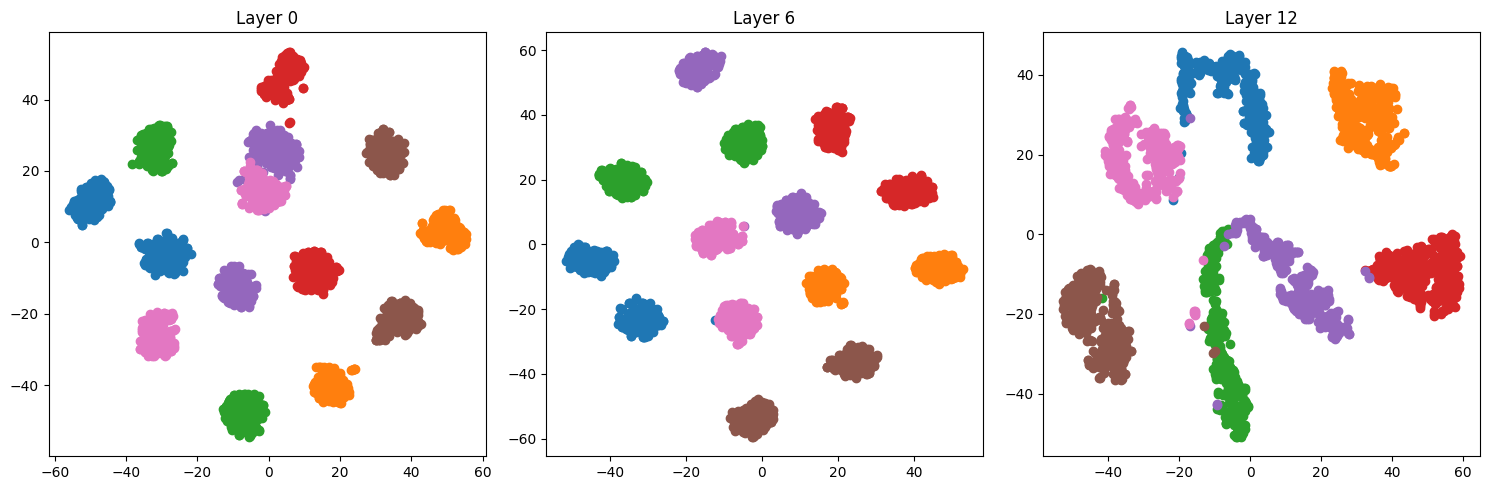

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# lets load the hidden states and check the shape
hidden_states = np.load("hidden_features/train_hidden_states.npy")
labels = np.array(train_df['labels'])
unique_labels = np.unique(labels)

# visualize the hidden states using tsne of a few layers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, layer in enumerate([0, 6, 12]):
    X_embedded = TSNE().fit_transform(hidden_states[:, layer, :])
    ax = axes[idx]
    for i in range(len(unique_labels)):
        ax.scatter(X_embedded[labels == unique_labels[i], 0], X_embedded[labels == unique_labels[i], 1], marker='o')
    ax.set_title(f"Layer {layer}")

plt.tight_layout()
plt.show()

### Similarity Metrics

In [27]:
# provided code:
import torch
from sklearn.metrics.pairwise import linear_kernel
import numpy as np


### TAKEN FROM HERE: https://github.com/minyoungg/platonic-rep/blob/main/metrics.py

## mutual KNN
def compute_nearest_neighbors(feats, topk=1):
    """
    Compute the nearest neighbors of feats
    Args:
        feats: a torch tensor of shape N x D
        topk: the number of nearest neighbors to return
    Returns:
        knn: a torch tensor of shape N x topk
    """
    assert feats.ndim == 2, f"Expected feats to be 2D, got {feats.ndim}"
    knn = (
        (feats @ feats.T).fill_diagonal_(-1e8).argsort(dim=1, descending=True)[:, :topk]
    )
    return knn

def mutual_knn(feats_A, feats_B, topk):
    """
    Computes the mutual KNN accuracy.

    Args:
        feats_A: A torch tensor of shape N x feat_dim
        feats_B: A torch tensor of shape N x feat_dim

    Returns:
        A float representing the mutual KNN accuracy
    """
    knn_A = compute_nearest_neighbors(feats_A, topk)
    knn_B = compute_nearest_neighbors(feats_B, topk)

    n = knn_A.shape[0]
    topk = knn_A.shape[1]

    # Create a range tensor for indexing
    range_tensor = torch.arange(n, device=knn_A.device).unsqueeze(1)

    # Create binary masks for knn_A and knn_B
    lvm_mask = torch.zeros(n, n, device=knn_A.device)
    llm_mask = torch.zeros(n, n, device=knn_A.device)

    lvm_mask[range_tensor, knn_A] = 1.0
    llm_mask[range_tensor, knn_B] = 1.0

    acc = (lvm_mask * llm_mask).sum(dim=1) / topk

    return acc.mean().item()


## CKA
def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]

    # Zero out the diagonal elements of K and L
    K_tilde = K.clone().fill_diagonal_(0)
    L_tilde = L.clone().fill_diagonal_(0)

    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (torch.sum(K_tilde * L_tilde.T))
        + (torch.sum(K_tilde) * torch.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * torch.sum(torch.mm(K_tilde, L_tilde)) / (m - 2))
    )

    HSIC_value /= m * (m - 3)
    return HSIC_value


def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = torch.eye(K.shape[0], dtype=K.dtype, device=K.device) - 1 / K.shape[0]
    return torch.trace(K @ H @ L @ H)

def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
        """Computes the unbiased Centered Kernel Alignment (CKA) between features."""

        if kernel_metric == 'ip':
            # Compute kernel matrices for the linear case
            K = torch.mm(feats_A, feats_A.T)
            L = torch.mm(feats_B, feats_B.T)
        elif kernel_metric == 'rbf':
            # COMPUTES RBF KERNEL
            K = torch.exp(-torch.cdist(feats_A, feats_A) ** 2 / (2 * rbf_sigma ** 2))
            L = torch.exp(-torch.cdist(feats_B, feats_B) ** 2 / (2 * rbf_sigma ** 2))
        else:
            raise ValueError(f"Invalid kernel metric {kernel_metric}")

        # Compute HSIC values
        hsic_fn = hsic_unbiased if unbiased else hsic_biased
        hsic_kk = hsic_fn(K, K)
        hsic_ll = hsic_fn(L, L)
        hsic_kl = hsic_fn(K, L)

        # Compute CKA
        #print('hsic', hsic_kl)
        cka_value = hsic_kl / (torch.sqrt(hsic_kk * hsic_ll) + 1e-6)
        return cka_value.item()


def cosine_similarity(feats_A, feats_B):
    """
    Compute the cosine similarity between two sets of features.
    Args:
        feats_A: a torch tensor of shape N x D
        feats_B: a torch tensor of shape N x D
    Returns:
        a torch tensor of shape N x N
    """
    assert feats_A.ndim == 2, f"Expected feats_A to be 2D, got {feats_A.ndim}"
    assert feats_B.ndim == 2, f"Expected feats_B to be 2D, got {feats_B.ndim}"
    feats_A = feats_A / torch.norm(feats_A, dim=1, keepdim=True)
    feats_B = feats_B / torch.norm(feats_B, dim=1, keepdim=True)
    return feats_A @ feats_B.T

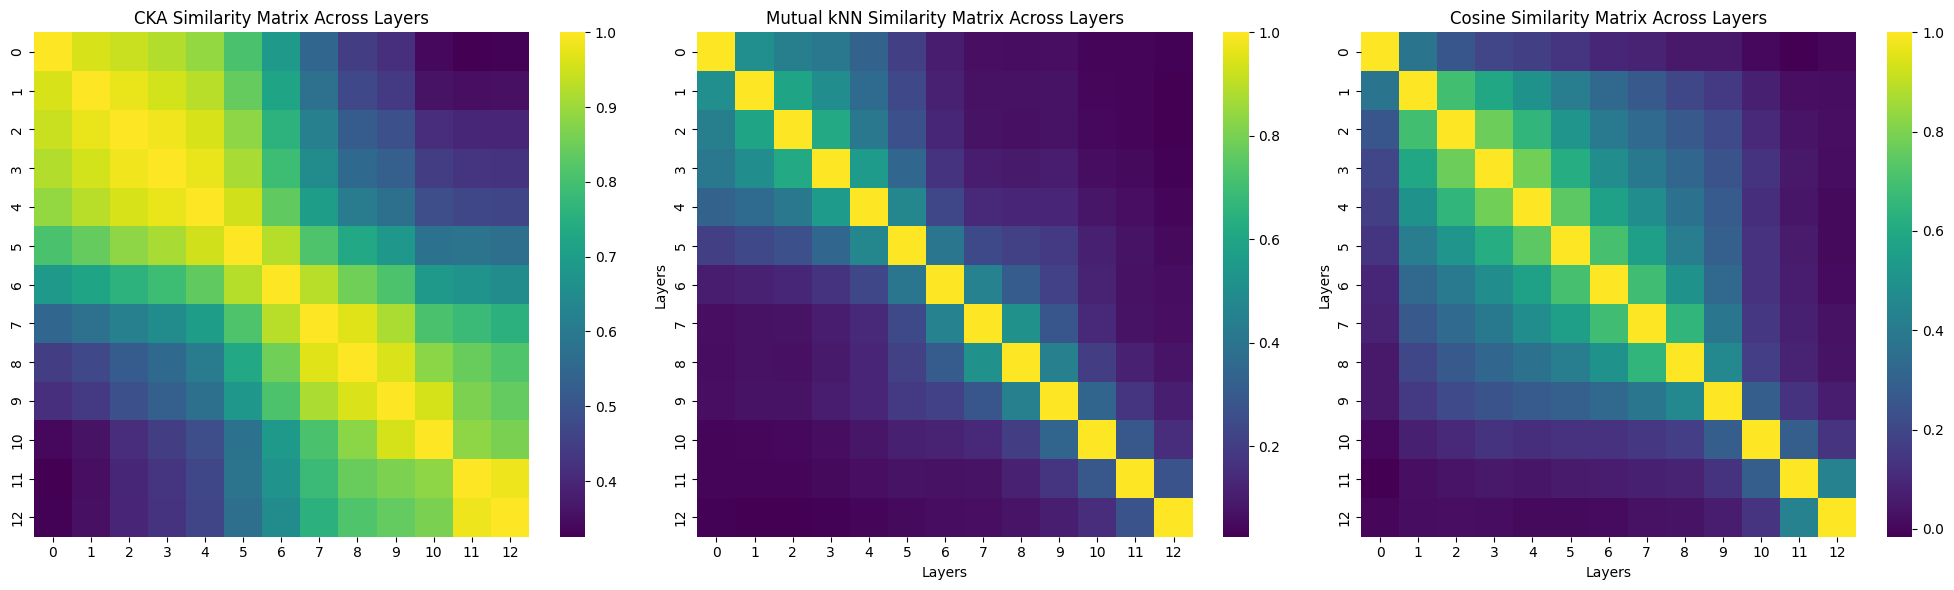

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("hidden_features/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

## Knowledge Distillation

In [29]:
# load teacher model from above training
# processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
# teacher_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
# teacher_model.load_state_dict(torch.load('/content/drive/MyDrive/Emotion Recognition Model/teacher_model.pt'))
teacher_model = model
teacher_model.to('cuda')
teacher_model.eval()

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


#### Student Model

In [30]:
from transformers import Wav2Vec2Config, Wav2Vec2ForSequenceClassification

# Define student model configuration
student_config = Wav2Vec2Config(
    hidden_size=256,  # Reduce hidden size
    num_hidden_layers=6,  # Fewer transformer layers
    num_attention_heads=4,  # Fewer attention heads
    num_labels=7  # Match the number of output labels
)

# Initialize student model
student_model = Wav2Vec2ForSequenceClassification(student_config)
student_model.to('cuda')  # Move to GPU if available


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=256, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)


#### Student model training

In [31]:
# define KD loss function
import torch.nn.functional as F

def kd_loss(student_logits, teacher_logits, labels, temperature=2.0, alpha=0.5):
    # Soft targets
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
    student_probs = F.log_softmax(student_logits / temperature, dim=-1)
    soft_loss = F.kl_div(student_probs, teacher_probs, reduction="batchmean") * (temperature ** 2)

    # Hard targets
    hard_loss = F.cross_entropy(student_logits, labels)

    # Combine losses
    return alpha * soft_loss + (1 - alpha) * hard_loss

In [ ]:
# Student Training Loop
from torch.optim import AdamW

# Optimizer for student model
optimizer = AdamW(student_model.parameters(), lr=5e-5)

# Training parameters
num_epochs = 5
temperature = 2.0
alpha = 0.5

teacher_model.to('cuda')
student_model.to('cuda')

for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0

    for i in range(len(train_dataset)):
        # Get batch from the dataset
        batch = train_dataset[i]
        inputs = batch['input_values'].unsqueeze(0).to('cuda')  # Add batch dimension
        labels = batch['labels'].unsqueeze(0).to('cuda')

        # Forward pass through teacher model
        with torch.no_grad():
            teacher_logits = teacher_model(inputs).logits

        # Forward pass through student model
        student_logits = student_model(inputs).logits

        # Compute distillation loss
        loss = kd_loss(student_logits, teacher_logits, labels, temperature, alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataset):.4f}")


Epoch 1/5, Loss: 2.0569
Epoch 2/5, Loss: 1.1128
Epoch 3/5, Loss: 0.8640


In [ ]:
# Evaluate Student Model
from sklearn.metrics import accuracy_score

student_model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]
        inputs = batch['input_values'].unsqueeze(0).to('cuda')
        labels = batch['labels'].unsqueeze(0).to('cuda')

        logits = student_model(inputs).logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9964


In [ ]:
# Save student model
torch.save(student_model.state_dict(), 'student_model.pt')


### Student-Teacher Comparison

In [ ]:
import os
import time

# Compare model size
teacher_model_size = os.path.getsize('/content/drive/MyDrive/Emotion Recognition Model/teacher_model.pt') / (1024 ** 2)  # Size in MB
student_model_size = os.path.getsize('/content/drive/MyDrive/Emotion Recognition Model/student_model.pt') / (1024 ** 2)  # Size in MB
print(f"Teacher Model Size: {teacher_model_size:.2f} MB")
print(f"Student Model Size: {student_model_size:.2f} MB")

# Compare inference time
def measure_inference_time(model, inputs):
    start_time = time.time()
    with torch.no_grad():
        _ = model(inputs)
    end_time = time.time()
    return end_time - start_time

batch = test_dataset[0]['input_values'].unsqueeze(0).to('cuda')  # Single input
teacher_time = measure_inference_time(teacher_model, batch)
student_time = measure_inference_time(student_model, batch)

print(f"Teacher Inference Time: {teacher_time:.4f} seconds")
print(f"Student Inference Time: {student_time:.4f} seconds")

# Compare accuracy
def evaluate_model(model, dataset):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for i in range(len(dataset)):
            batch = dataset[i]
            inputs = batch['input_values'].unsqueeze(0).to('cuda')
            labels = batch['labels'].unsqueeze(0).to('cuda')

            logits = model(inputs).logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# teacher_model.load_state_dict(torch.load('teacher_model.pt'))
teacher_model.eval()
teacher_acc = evaluate_model(teacher_model, test_dataset)
student_acc = evaluate_model(student_model, test_dataset)

print(f"Teacher Accuracy: {teacher_acc:.4f}")
print(f"Student Accuracy: {student_acc:.4f}")



Teacher Model Size: 360.84 MB
Student Model Size: 60.96 MB
Teacher Inference Time: 0.0199 seconds
Student Inference Time: 0.0086 seconds
Teacher Accuracy: 1.0000
Student Accuracy: 0.9964


### Feature Extraction and Similarity Metrics on Student model

In [ ]:
# slightly altered feature extraction code for student model
def extract_features(model, processor, dataset, output_dir, split_name):
    model.to(device)

    # Dynamically infer hidden size and number of layers
    hidden_size = model.config.hidden_size
    num_layers = model.config.num_hidden_layers + 1  # Add 1 for the input layer's hidden state

    # Initialize hidden states tensor
    hidden_states = torch.zeros((len(dataset), num_layers, hidden_size)).to(device)

    # Iterate over the dataset
    for i, example in enumerate(tqdm(dataset, desc=f"Extracting {split_name} features")):
        inputs = example['input_values'].unsqueeze(0).to(device)  # Use dataset class structure

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # Average the hidden states over the time axis for each layer
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        # Save intermediate results every 100 steps
        if i > 0 and i % 100 == 0:
            intermediate_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
            np.save(intermediate_path, hidden_states.cpu().numpy())
            # print(f"Saved intermediate features for {split_name}: {intermediate_path}")

    # Save the final features
    final_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    np.save(final_path, hidden_states.cpu().numpy())
    print(f"Saved final features for {split_name}: {final_path}")

# Extract features for the student model
print("Extracting student model hidden features")
output_dir = "./student_hidden_features"
os.makedirs(output_dir, exist_ok=True)

# Train and test feature extraction
extract_features(student_model, processor, train_dataset, output_dir, "train")
extract_features(student_model, processor, test_dataset, output_dir, "test")


Extracting student model hidden features


Extracting train features: 100%|██████████| 2240/2240 [00:29<00:00, 74.83it/s]


Saved final features for train: ./student_hidden_features/train_hidden_states.npy


Extracting test features: 100%|██████████| 560/560 [00:05<00:00, 103.11it/s]

Saved final features for test: ./student_hidden_features/test_hidden_states.npy


#### Visualize student hidden features

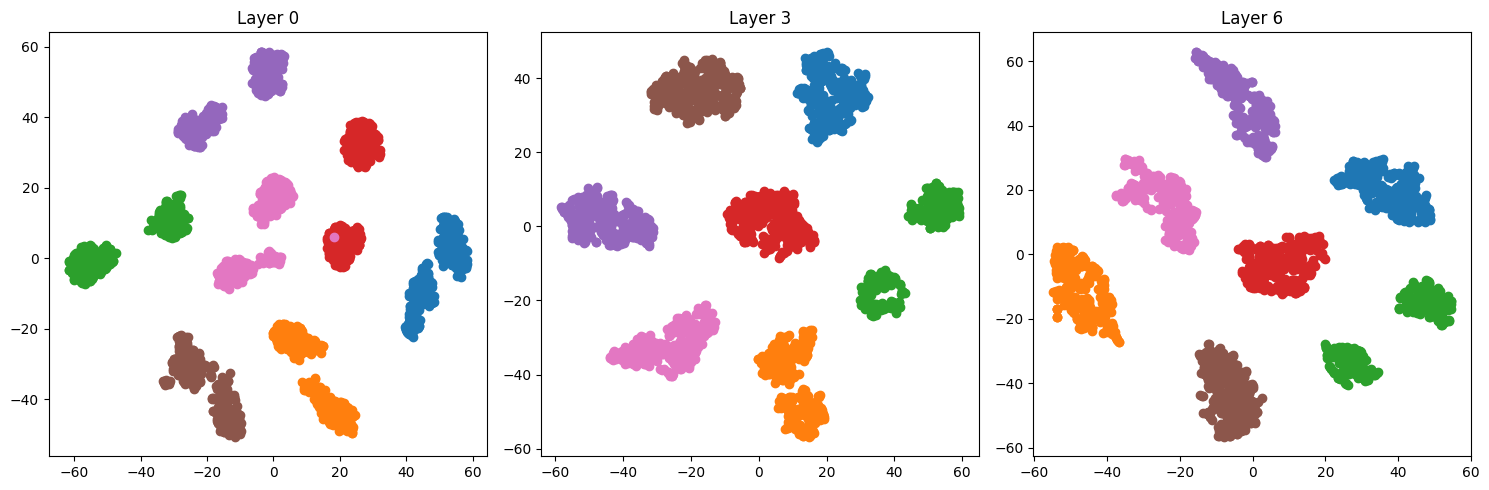

In [ ]:
hidden_states = np.load("student_hidden_features/train_hidden_states.npy")
labels = np.array(train_df['labels'])
unique_labels = np.unique(labels)

# visualize the hidden states using tsne of a few layers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, layer in enumerate([0, 3, 6]):
    X_embedded = TSNE().fit_transform(hidden_states[:, layer, :])
    ax = axes[idx]
    for i in range(len(unique_labels)):
        ax.scatter(X_embedded[labels == unique_labels[i], 0], X_embedded[labels == unique_labels[i], 1], marker='o')
    ax.set_title(f"Layer {layer}")

plt.tight_layout()
plt.show()

#### Similarity Metrics

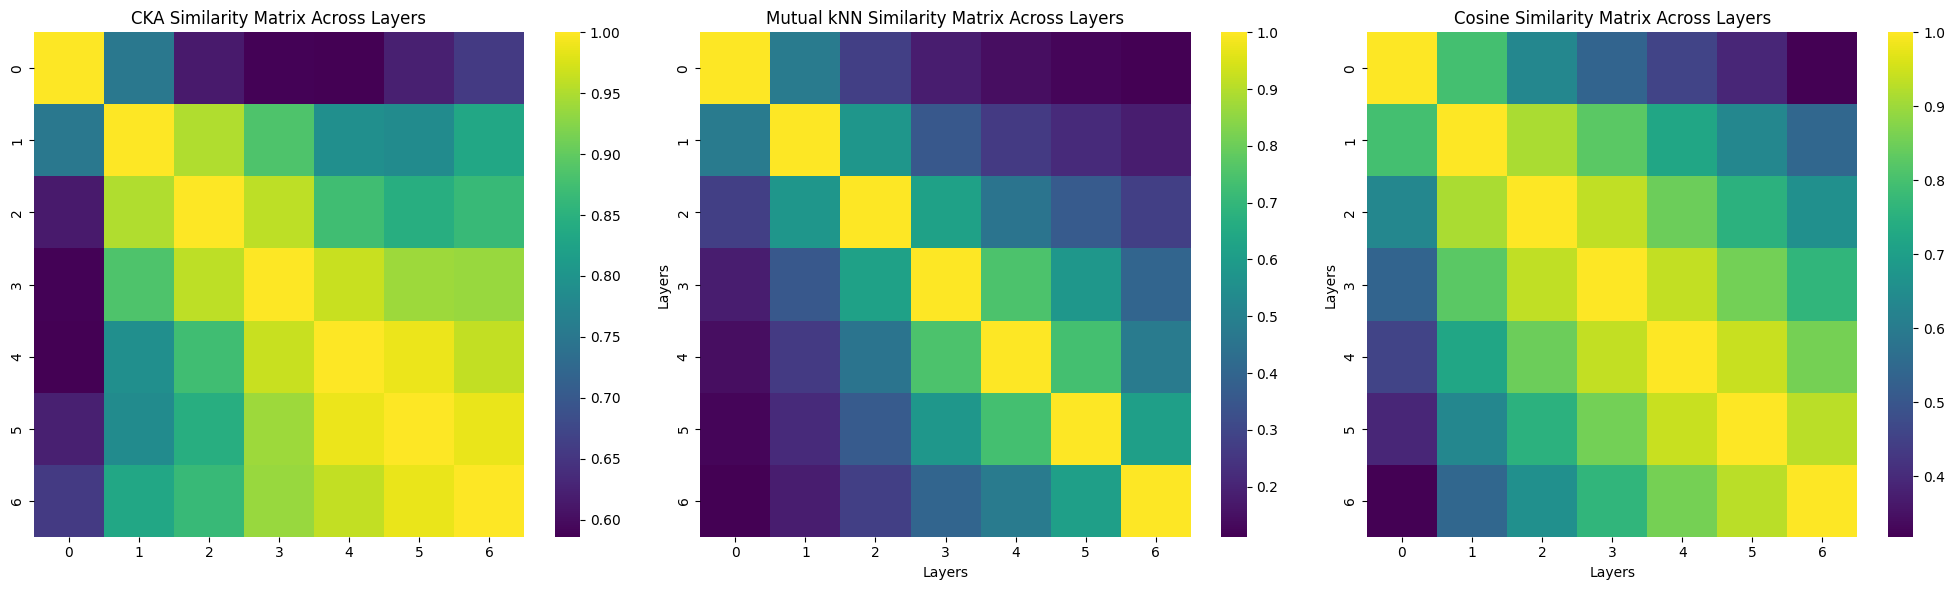

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("student_hidden_features/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()